# 1 Author

# 2 Problem formulation

- 描述：本项目旨在探索无监督学习方法，特别是 K-means 聚类，来分析和理解 genki4k 数据集中的人脸图片。我们的目标是通过提取深度特征，识别可能存在的模式或类别，并探索这些类别可能代表的含义（例如不同的表情或特征）。

- 兴趣点：这个问题的有趣之处在于，它允许我们深入理解数据集中潜在的、未标记的特征，从而可能揭示出我们之前没有意识到的模式。

# 3 Machine Learning pipeline

- 输入：genki4k 数据集中的人脸图片。
- 转换：使用预训练的 ResNet50 模型提取特征。
- 模型：应用 K-means 聚类算法对特征进行聚类。
- 输出：聚类标签和聚类的可视化。
- 数据流：从原始图片到特征提取，再到聚类和结果可视化。

# 4 Transformation stage


- 转换描述：使用预训练的 ResNet50 模型进行特征提取，这能够捕捉到图片中的深度特征，这些特征对于聚类分析来说至关重要。

- 输入与输出：输入为原始图片，输出为深度特征向量。

- 选择原因：预训练的 CNN 模型能够有效提取复杂图像中的关键特征，这对于后续的聚类分析是必需的。

# 5 Modelling

选择适合新问题的模型。

# 6 Methodology

类似于基础部分，但可能包括额外或不同的评价指标。

导入一些必要的包：

In [2]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# 7 Dataset

- 可能包括额外的注释或标签，如性别。
- 根据问题的不同，预处理可能有所不同。

数据集预处理：

- Data loading

In [3]:
class Genki4kDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

- Pre-Processing

In [4]:
# 数据增强
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = '/root/MiniProject/MiniProject/genki4k/files'
data_dir = 'C:/Users/LENOVO/Desktop/MiniProject/MiniProject/genki4k/files' 
dataset = Genki4kDataset(data_dir, transform=data_transforms)

In [5]:
# 加载预训练模型并提取特征
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的 ResNet 模型
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for inputs in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
features = np.array(features)

In [6]:
# 标准化处理：
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [7]:
# 应用 PCA 进行降维
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [8]:
# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features_scaled)

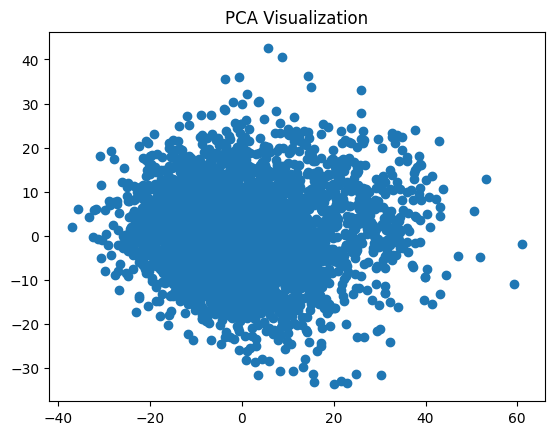

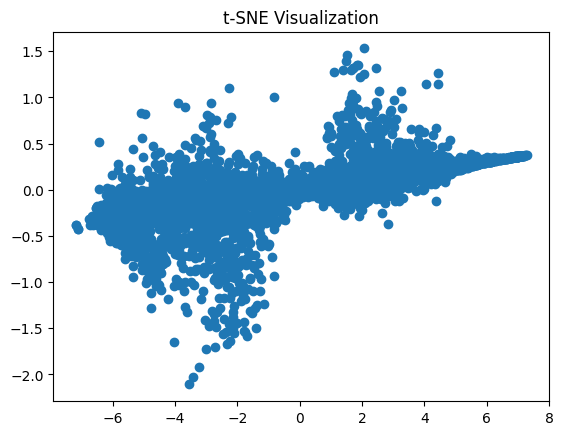

In [12]:
# 可视化 PCA 和 t-SNE 的结果
plt.scatter(features_pca[:, 0], features_pca[:, 1])
plt.title('PCA Visualization')
plt.show()

plt.scatter(features_tsne[:, 0], features_tsne[:, 1])
plt.title('t-SNE Visualization')
plt.show()

# 8 Results

对新问题进行实验和分析。

- 应用 K-means 聚类


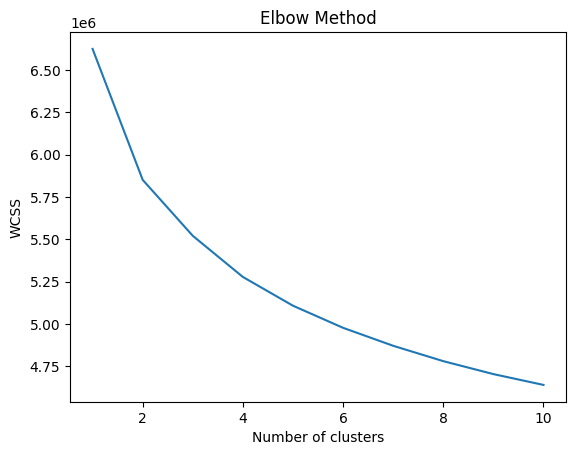

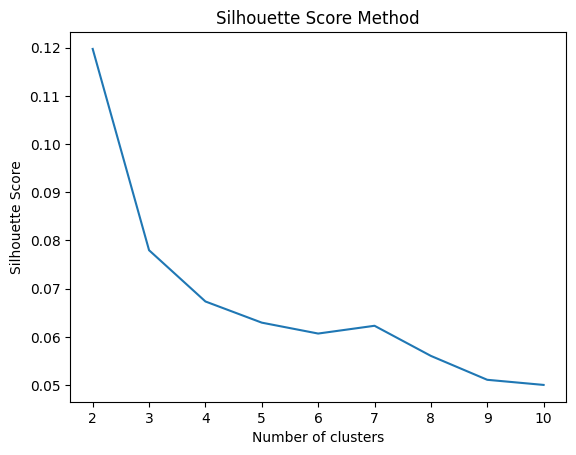

In [10]:
# 肘部法则
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_scores = []
for i in range(2, 11):  # 轮廓系数至少需要2个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

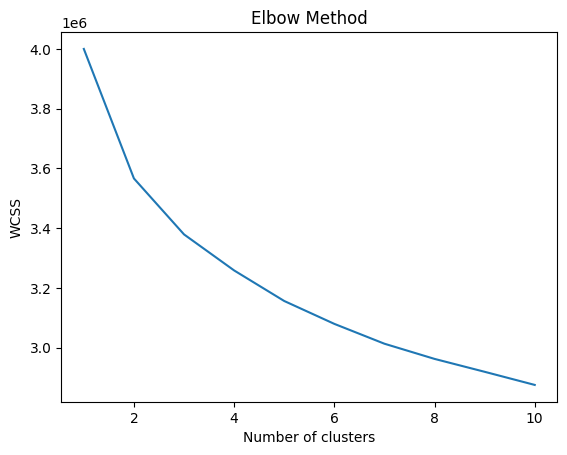

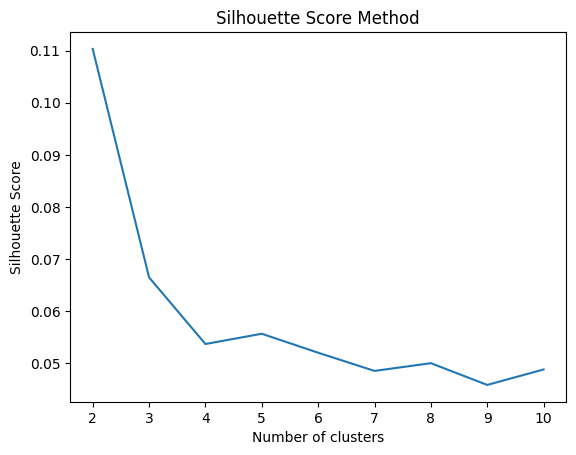

In [11]:
# 肘部法则
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_scores = []
for i in range(2, 11):  # 轮廓系数至少需要2个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_scaled)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

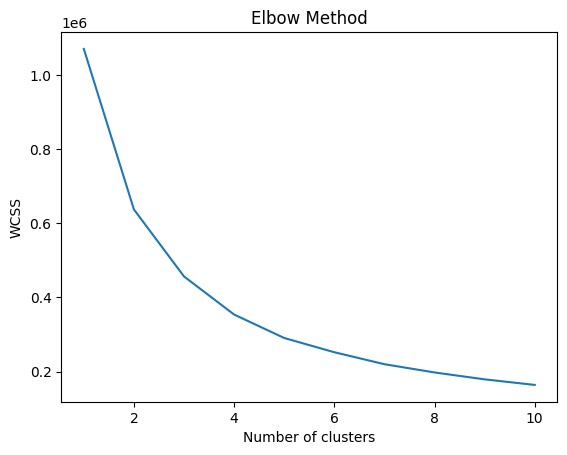

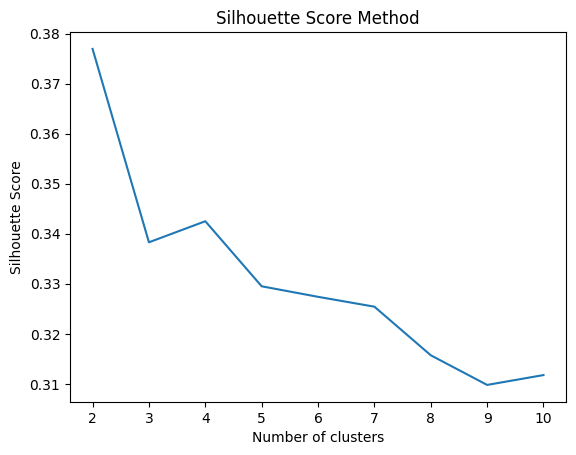

In [13]:
# 肘部法则
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_scores = []
for i in range(2, 11):  # 轮廓系数至少需要2个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_pca)
    score = silhouette_score(features_pca, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

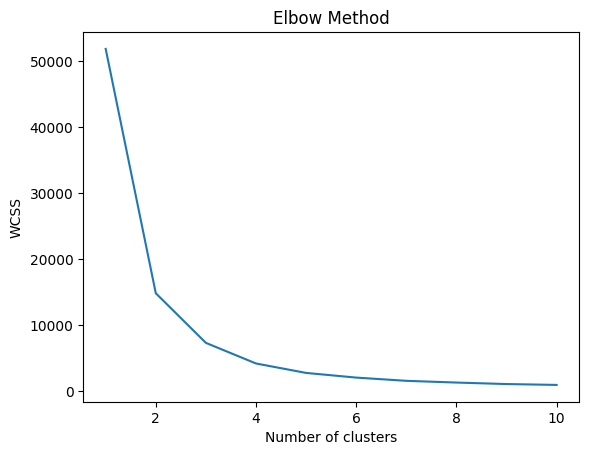

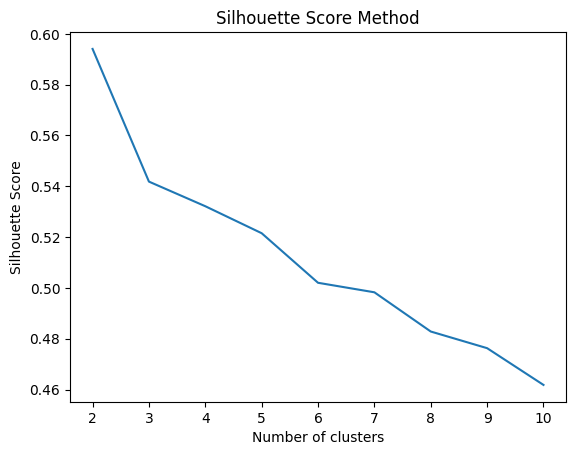

In [14]:
# 肘部法则
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_tsne)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_scores = []
for i in range(2, 11):  # 轮廓系数至少需要2个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_tsne)
    score = silhouette_score(features_tsne, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

- 肘部法则图：展示了聚类数量与聚类内误差平方和（WCSS）的关系。随着聚类数量的增加，WCSS 通常会减少，因为样本会更接近它们的中心点。肘部法则图通常呈现一个向下的弯曲，而“肘部”点是曲线开始平缓的地方，即增加更多聚类不会显著降低 WCSS 的点。从您的图中可以看出，当聚类数量从2增加到3时，WCSS的下降速度变缓，因此可能的最佳聚类数量为3。

- 轮廓系数图：表示不同聚类数量下的轮廓系数值。轮廓系数衡量了样本与同一聚类中其他样本的相似程度以及与最近的其他聚类样本的不同程度。轮廓系数的范围是 -1 到 1，值越高表示聚类效果越好。在您的图中，轮廓系数在聚类数量为2时最高，这表明在当前数据集上，两个聚类提供了最佳的分隔效果。

In [19]:
# 选择聚类的数量
n_clusters = 2 # 您可以根据需要调整聚类的数量

# 使用显式的 n_init 参数值, 执行K-means聚类
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(features_tsne)

KMeans(n_clusters=2, n_init=10, random_state=42)

3. 分析聚类结果

Silhouette Score: 0.5940563082695007


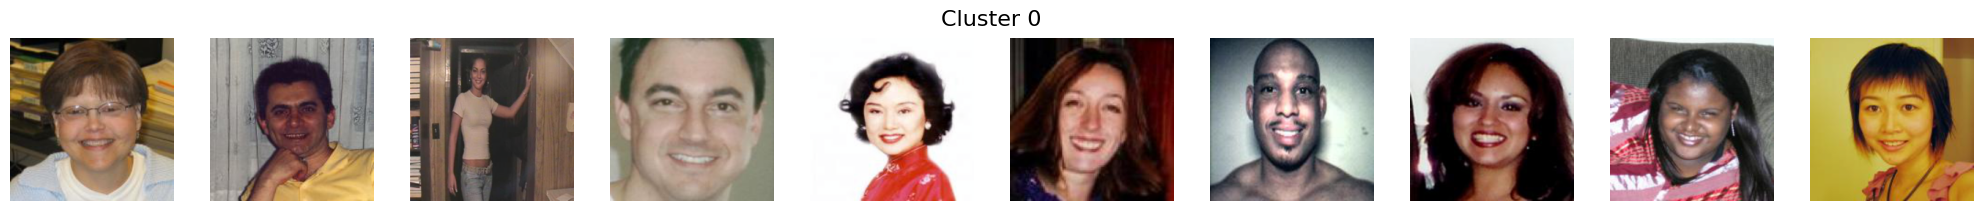

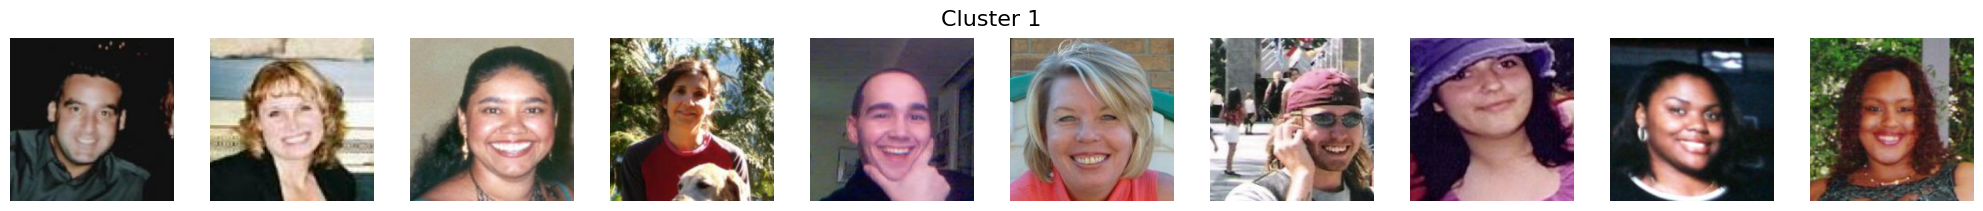

In [20]:

# 计算轮廓系数
silhouette_avg = silhouette_score(features_tsne, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

labels = kmeans.labels_

for cluster in range(n_clusters):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2), constrained_layout=True)
    fig.suptitle(f'Cluster {cluster}', fontsize=16)
    cluster_indices = np.where(labels == cluster)[0]
    for ax, idx in zip(axes, cluster_indices[:10]):
        img = dataset[idx].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


# 9 Conclusions

讨论结果、潜在改进及未来工作，针对高级部分。